In [9]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.fftpack import fft,ifft
import pandas as pd
from scipy.optimize import minimize

In [10]:
# N=20取bin的函数

def databin_20(lst):
    result = [[]]    
    length = len(lst)
    n = 0
    for i in range(length):
        result[-1].append(math.log(lst[i],10))
        n = n+1
        if n == 50:
            n = 0
            result.append([])
    result.pop()
    output=[]
    for j in range(len(result)):
        output.append(np.mean(result[j])) 
    return output

def databin_20_std(lst):
    result = [[]]
    length = len(lst)
    n = 0
    for i in range(length):
        result[-1].append(math.log(lst[i],10))
        n = n+1
        if n == 50:
            n = 0
            result.append([])
    result.pop()
    output=[]
    for j in range(len(result)):
        output.append(np.std(result[j]))
    return output


In [11]:
#光变曲线

# 提取数据长度
data = pd.read_csv("0.3_10_tb10(00).csv")  
counts_data = data['RATE']
dt=10
mean_x_data = np.mean(counts_data)

N=len(counts_data)
N_randomlc=len(counts_data)

omega = []
POW = []
DFT = []
fr = []
fi = []
f1 = []
f2 = []
p = []
f = []


counts_list=[None for i in range(500)]

# 500条光变曲线
for a in range(500):
    f_b=1.7E-4
    alpha_H=3.8
    alpha_L=1.0
    for j in range(1,int(N_randomlc)+1):
        omega.append(j/(N_randomlc*dt))
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/f_b)**(alpha_H-alpha_L)))*0.005)
        DFT.append(complex(np.sqrt(POW[-1]),np.sqrt(POW[-1])))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a]=counts


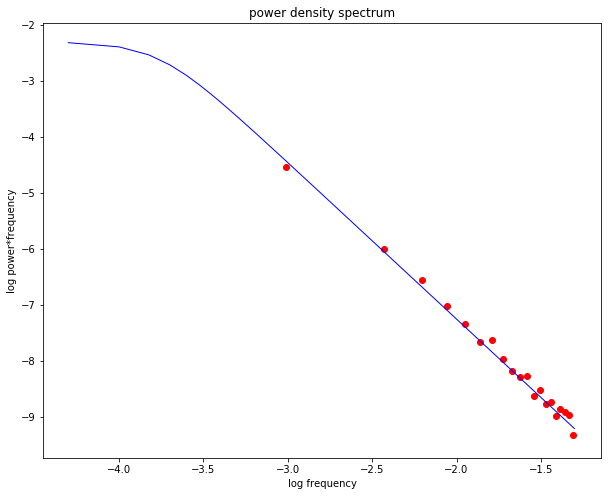

In [12]:
#周期图

per_list=[None for i in range(500)]

for a in range(500):
    nf = N/2
    df = 1/(dt*N)
    F_a = np.arange(1,nf+1)
    F = [i*df for i in F_a]
    F1 = F[0:int(nf)]
    dft   = fft(counts_list[a])
    dft_1 = dft[1:int(nf)+1]
    per = (abs(dft_1)**2)

    per_list[a] = per


    
# per 取log_bin    
for a in range(500):
    per_binned = databin_20(per_list[a])
    per_list[a] = per_binned
    
    
# 500条 binned_per 得ADM
per_everypoint_list = []
for i in range(len(per_list[0])):
    per_everypoint_list.append([])
ADM = []
for m in range(len(per_list[0])):
    for n in range(500):
        per_everypoint_list[m].append((per_list[n][m]))
for m in range(len(per_list[0])):
    ADM.append(np.mean(per_everypoint_list[m]))


F1_binned=databin_20(F1)
ADM_times_f = np.array(F1_binned) + np.array(ADM)


POW1=POW[0:int(nf)]
P_TIMES_F = np.multiply(np.array(F1),np.array(POW1))
F1_log = [math.log(i,10) for i in F1]
PTF_log = [math.log(i,10) for i in P_TIMES_F]


plt.figure(figsize=(10,8))
plt.plot(F1_log,PTF_log,color="b",linewidth=1)
plt.scatter(F1_binned,ADM_times_f,color="r",linewidth=1)    
plt.xlabel("log frequency")
plt.ylabel("log power*frequency")
plt.title("power density spectrum")
plt.show()

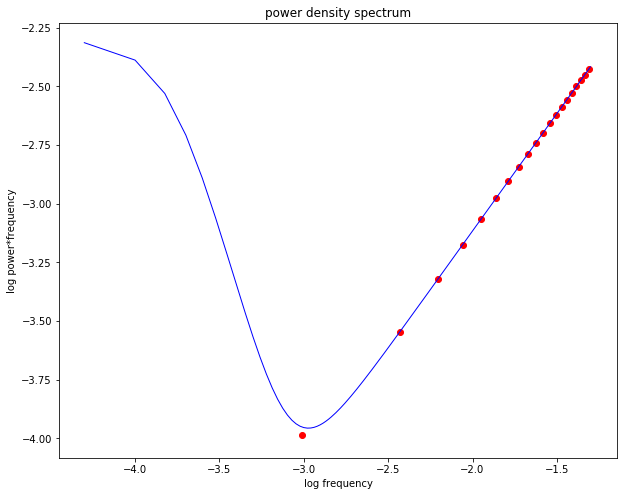

In [13]:
# 加上泊松项？
ADM_with_poisson = [math.log(10**(i)+2/mean_x_data,10) for i in ADM]
F1_binned = databin_20(F1)
ADM_times_f_ps = np.array(F1_binned) + np.array(ADM_with_poisson)        


POW1=POW[0:int(nf)]
POW_ps = [i+2/mean_x_data for i in POW1]
PTF_ps = np.multiply(np.array(F1),np.array(POW_ps))
F1_log = [math.log(i,10) for i in F1]
PTF_ps_log = [math.log(i,10) for i in PTF_ps]




plt.figure(figsize=(10,8))
plt.plot(F1_log,PTF_ps_log,color="b",linewidth=1)
plt.scatter(F1_binned,ADM_times_f_ps,color="r",linewidth=1)  
plt.xlabel("log frequency")
plt.ylabel("log power*frequency")
plt.title("power density spectrum")
plt.show()

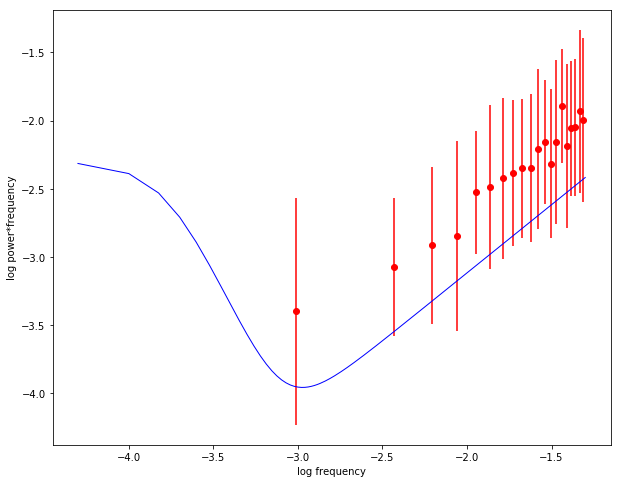

In [14]:
# 从数据得到参考周期图

data = pd.read_csv("0.3_10_tb10(00).csv")  
data['RATE'] = data['RATE'].fillna(data['RATE'].mean())


dt=10
counts_data = data['RATE']
N=len(counts_data)
pnum = np.arange(len(counts_data))
t = [i*dt for i in pnum]


nf = N/2
df = 1/(dt*N)
mean_x = np.mean(counts_data)
dft = fft(counts_data)
dft1= dft[1:int(nf)+1]
per_data = (abs(dft1)**2)*2*dt/((mean_x**2)*N)
p_times_f_data = np.multiply(np.array(F1),np.array(per_data))


# 数据分bin
per_data_binned = databin_20(per_data)
per_data_b_std = databin_20_std(per_data)
p_times_f_data_b = np.array(F1_binned)+np.array(per_data_binned)



plt.figure(figsize=(10,8))
plt.scatter(F1_binned,p_times_f_data_b,color="r",linewidth=1) 
plt.errorbar(F1_binned,p_times_f_data_b,yerr=per_data_b_std, fmt='.r')
plt.plot(F1_log,PTF_ps_log,color="b",linewidth=1) 
plt.xlabel("log frequency")
plt.ylabel("log power*frequency")
plt.show()

In [15]:
# chi2 =（每一点500平均值 - 每一点数据得到）/ 每一点的500标准差  求和

chi2=0
for i in range(len(ADM_with_poisson)):
    chi2 = chi2+(((ADM_with_poisson[i]-per_data_binned[i])/per_data_b_std[i])**2)

print (chi2)


15.234249450671516


In [16]:
def chi2_of_model(A):
    data = pd.read_csv("0.3_10_tb10(00).csv")
    data['RATE'] = data['RATE'].fillna(data['RATE'].mean())
    counts_data = data['RATE']
    dt=10
    mean_x_data = np.mean(counts_data)
    N=len(counts_data)
    N_randomlc=len(counts_data)
    
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    f2 = []
    p = []
    f = []
    
    counts_list=[None for i in range(500)]
    
    
    # 500条光变曲线
    for a in range(500): 
        f_b=1.7E-4
        alpha_H=3.8
        alpha_L=1.0
        for j in range(1,int(N_randomlc)+1):
            omega.append(j/(N_randomlc*dt))
            POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/f_b)**(alpha_H-alpha_L)))*A)
            DFT.append(complex(np.sqrt(POW[-1]),np.sqrt(POW[-1])))
            s1=np.random.normal(loc=0.0, scale=1.0, size=None)
            s2=np.random.normal(loc=0.0, scale=1.0, size=None)
            fr.append((DFT[-1].real)*s1)
            fi.append((DFT[-1].imag)*s2)
            f1.append(complex(fr[-1],fi[-1]))
        counts = ifft(f1)
        counts_list[a]=counts
    
    
    #周期图
    per_list=[None for i in range(500)]
    for a in range(500):
        nf = N/2 
        df = 1/(dt*N)
        F_a = np.arange(1,nf+1)
        F = [i*df for i in F_a]
        F1 = F[0:int(nf)]
        mean_x = np.mean(counts_list[a])
        x_new  = [i-mean_x for i in counts_list[a]]
        dft   = fft(counts_list[a])
        dft_1 = dft[1:int(nf)+1]
        per = (abs(dft_1)**2)
        per_list[a] = per
    
    
    
    # per 取log_bin    
    for a in range(500):
        per_binned = databin_20(per_list[a])
        per_list[a] = per_binned
    
    
    # 500条 binned_per 得ADM
    per_everypoint_list = []
    for i in range(len(per_list[0])):
        per_everypoint_list.append([])
    ADM = []
    for m in range(len(per_list[0])):
        for n in range(500):
            per_everypoint_list[m].append((per_list[n][m]))
    for m in range(len(per_list[0])):
        ADM.append(np.mean(per_everypoint_list[m]))
    
    
    # 加上泊松项？
    ADM_with_poisson = [math.log(10**(i)+2/mean_x_data,10) for i in ADM]
    F1_binned = databin_20(F1)
    ADM_times_f_ps = np.array(F1_binned) + np.array(ADM_with_poisson)
    
    
    # 从数据得到参考周期图
    pnum = np.arange(len(counts_data))
    t = [i*dt for i in pnum]
    
    nf = N/2
    df = 1/(dt*N)
    F_num = np.arange(1,nf)
    F = [i*df for i in F_num]
    mean_x = np.mean(counts_data)
    dft = fft(counts_data)
    dft1= dft[1:int(nf)+1]
    per_data = (abs(dft1)**2)*2*dt/((mean_x**2)*N)
    
    
    # 数据分bin
    per_data_binned = databin_20(per_data)
    per_data_b_std = databin_20_std(per_data)
    p_times_f_data_b = np.array(F1_binned)+np.array(per_data_binned)
    
    
    chi2=0
    for i in range(len(ADM_with_poisson)):
        chi2 = chi2+(((ADM_with_poisson[i]-per_data_binned[i])/per_data_b_std[i])**2)    
    
    print('chi2 of this time = ',chi2)
    
    return (chi2)

In [17]:
print(chi2_of_model(0.005))

chi2 of this time =  15.266206028339942
15.266206028339942


In [18]:
print(chi2_of_model(0.005))

chi2 of this time =  15.197830968834293
15.197830968834293


In [19]:
print(chi2_of_model(0.005))

chi2 of this time =  15.18402677785078
15.18402677785078


In [20]:
print(chi2_of_model(0.005))

chi2 of this time =  15.254854904816145
15.254854904816145


In [ ]:
15.234
15.266
15.197
15.184
15.254